In [1]:
import json
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from scipy.optimize import minimize
from matplotlib import gridspec


In [2]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [3]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [4]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [5]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [6]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [7]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [8]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [9]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [10]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [11]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [12]:
#Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [13]:
#NelderMead
class NelderMead:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='nelder-mead', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [14]:
#BFGS
class BFGS:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='BFGS', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [15]:
#Newton-CG
class NewtonCG:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='Newton-CG', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [16]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


In [17]:
#Loader to test different methods with same RBM initalization
def minLoader(minimizer, par, N, M, B, A0):
    if minimizer == 'GradDescent':
        gradDescent = GradDescent(N, B, A0)
        gd = gradDescent(N, M,par)
        return gd
    if minimizer == "NelderMead":
        nelderMead = NelderMead(N,B,A0)
        nm = nelderMead(N,M,par)
        return nm
    if minimizer == "BFGS":
        bfgs = BFGS(N,B,A0)
        bf = bfgs(N,M,par)
        return bf
        
        
    

## Other Minimization Testing

In [18]:
N=2
M=1
B = np.pi
A0 = 1

In [19]:
par = ranRBMpar(N,M)
H = hamiltonian(N, B, A0)
mingd = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)

Optimization terminated successfully.
         Current function value: -1.898404
         Iterations: 26
         Function evaluations: 696
         Gradient evaluations: 58


In [20]:
print(mingd[0])

[ 0.15610069  2.06083417  0.02252263  3.20643331 -3.25321169  1.49212381
 -0.49642057  0.57687828  1.64439385  0.3420571 ]


In [21]:
par = ranRBMpar(N,M)
H = hamiltonian(N, B, A0)
minop = minimize(varEnergy, par,args= (N,M,H), method='BFGS', options={'disp': True})
print(minop.x)


Optimization terminated successfully.
         Current function value: -1.898452
         Iterations: 40
         Function evaluations: 540
         Gradient evaluations: 45
[-4.73444546  1.82628609 -2.34921744 -9.23043278 15.2823411   3.7619625
 -2.28866121  4.59610838  4.39011251 -2.23468164]


In [22]:
opState = RBM_ansatz(minop.x,N, M)
print(opState)
opEng = varEnergy(minop.x,N, M, H)
print(opEng)
groundState = GroundState(N,B,A0)
ed = groundState()
edEng = ed[0][0]
edState = ed[0][1]
print(edState)
print(edEng)
Error = err(opState,edState ,opEng,edEng)
print(Error)

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 8.93168255e-07+3.22366361e-07j]
 [ 2.60869926e-02+1.51241860e-01j]
 [-1.67960896e-01-9.73771829e-01j]
 [-7.55914856e-04+1.53589694e-03j]]
-1.8984524619735763
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [-0.15347555]
 [ 0.98815245]
 [ 0.        ]]
-1.8984541547378078
(1.6927642314534808e-06, 1.4651948725408204e-06)


In [23]:
optimize = Optimize(N,B,A0)
op = optimize(N,M)


NameError: name 'Optimize' is not defined

## Comparison Histograms

In [25]:
#Parameter definition 
N= 2
M=1
B = np.pi
A0 = 1

gdResults = [] #gives ground state estimation at each iteration of gd
gdState = []
gdTime = []
gdEngErr = []
gdStateErr = []

edState = []
edTime = []
ActualEng = []

zeroOneState = []
zeroOneTime = []
zeroOneEngErr = []
zeroOneStateErr = []

nOneOneState = []
nOneOneTime = []
nOneOneEngErr = []
nOneOneStateErr = []

smallState = []
smallTime = []
smallEngErr = []
smallStateErr = []

hisIt = np.arange(50)

In [26]:
for i in range(len(hisIt)):
    par = ranRBMpar(N,M)
    
    #gradient descent
    gd = minLoader('GradDescent', par,N, M, B, A0)
    gdResults.append(gd)
    gdState.append(gd[0])
    gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    edState.append(ed[0])
    edTime.append(ed[1])
    
    #Nelder Mead
    zeroOne = minLoader('GradDescent', 1*par,N, M, B, A0)
    zeroOneState.append(ten[0])
    zeroOneTime.append(ten[1])
    
    #BFGS
    nOneOne = minLoader('GradDescent', (1-2*par),N, M, B, A0)
    hunState.append(hun[0])
    hunTime.append(hun[1])
    
    #Newton-CG
    small = minLoader('GradDescent', 0.1*par,N, M, B, A0)
    smallState.append(small[0])
    smallTime.append(small[1])
    
    
    #Error
    gdEngTemp = gd[0][2]
    tenEngTemp = ten[0][2]
    hunEngTemp = hun[0][2]
    edEngTemp = ed[0][0]
    smallEngTemp = small[0][2]
    
    ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    zeroOneStateTemp = zeroOne[0][1]
    hunStateTemp = hun[0][1]
    smallStateTemp = small[0][1]
    
    gdErrTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    zeroOneErrTemp = err(zeroOneStateTemp,edStateTemp,zeroOneEngTemp,edEngTemp)
    hunErrTemp = err(hunStateTemp,edStateTemp,hunEngTemp,edEngTemp)
    smallErrTemp = err(smallStateTemp,edStateTemp,smallEngTemp,edEngTemp)
    
    gdEngErr.append(gdErrTemp[0])
    gdStateErr.append(gdErrTemp[1])
    zeroOneEngErr.append(zeroOneErrTemp[0])
    zeroOneStateErr.append(zeroOneErrTemp[1])
    hunEngErr.append(hunErrTemp[0])
    hunStateErr.append(hunErrTemp[1])
    smallEngErr.append(smallErrTemp[0])
    smallStateErr.append(smallErrTemp[1])


Optimization terminated successfully.
         Current function value: -1.898410
         Iterations: 27
         Function evaluations: 840
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: -1.898410
         Iterations: 27
         Function evaluations: 840
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 35
         Function evaluations: 1200
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: -1.820781
         Iterations: 5
         Function evaluations: 240
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -1.898448
         Iterations: 29
         Function evaluations: 828
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: -1.898448
         Iterations: 29
         Function evalua

Optimization terminated successfully.
         Current function value: -1.820722
         Iterations: 7
         Function evaluations: 276
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -1.820722
         Iterations: 7
         Function evaluations: 276
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -1.820725
         Iterations: 6
         Function evaluations: 276
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -1.820783
         Iterations: 5
         Function evaluations: 240
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -1.898441
         Iterations: 24
         Function evaluations: 732
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: -1.898441
         Iterations: 24
         Function evaluations

Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 17
         Function evaluations: 444
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 17
         Function evaluations: 444
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 70
         Function evaluations: 1956
         Gradient evaluations: 163
Optimization terminated successfully.
         Current function value: -1.820780
         Iterations: 5
         Function evaluations: 240
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -1.898420
         Iterations: 26
         Function evaluations: 804
         Gradient evaluations: 67
Optimization terminated successfully.
         Current function value: -1.898420
         Iterations: 26
         Function evalua

Optimization terminated successfully.
         Current function value: -1.898453
         Iterations: 35
         Function evaluations: 1128
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: -1.898453
         Iterations: 35
         Function evaluations: 1128
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: -1.820739
         Iterations: 6
         Function evaluations: 276
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -1.820775
         Iterations: 5
         Function evaluations: 240
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -1.898421
         Iterations: 20
         Function evaluations: 480
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: -1.898421
         Iterations: 20
         Function evaluat

Optimization terminated successfully.
         Current function value: -1.820788
         Iterations: 4
         Function evaluations: 192
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: -1.820788
         Iterations: 4
         Function evaluations: 192
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: -1.820734
         Iterations: 6
         Function evaluations: 276
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -1.820776
         Iterations: 5
         Function evaluations: 240
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 24
         Function evaluations: 528
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 24
         Function evaluations

In [27]:
stateErr = [smallStateErr,hunStateErr,gdStateErr]
engErr = [smallEngErr,hunEngErr,gdEngErr]
runTime = [smallTime,hunTime, gdTime]

Text(0, 0.5, 'Runtime')

<Figure size 432x288 with 0 Axes>

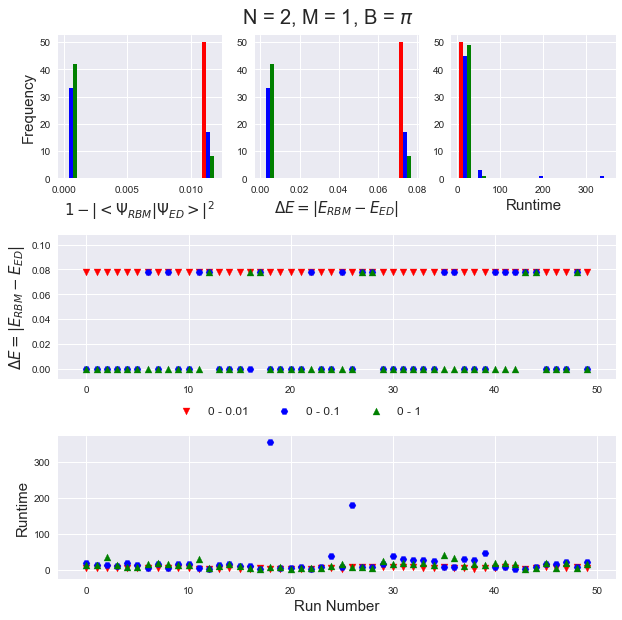

In [28]:


labels = ['0 - 0.01','0 - 0.1', '0 - 1']
colors = ['red','blue','green']
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=3, hspace = 0.4)
ttl.set_position([.5, 0.92])



ax1 = plt.subplot(gs[0, 0])
ax1 .hist(stateErr, bins=10, label=labels, color=colors) 
ax1 .set_xlabel("$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$",size = 15)
ax1.set_ylabel("Frequency",size = 15)



ax2 = plt.subplot(gs[0, 1])
ax2.hist(engErr, bins=10, color=colors) 
ax2.set_xlabel("$\Delta E = |E_{RBM}-E_{ED}|$",size = 15)



ax3 = plt.subplot(gs[0, 2])
ax3.hist(runTime, bins=10,color=colors) 
ax3.set_xlabel("Runtime",size = 15)


ax4 = plt.subplot(gs[1, :])
ax4.scatter(hisIt,engErr[0],color=colors[0],marker ='v') 
ax4.scatter(hisIt,engErr[1],color=colors[1],marker ='H') 
ax4.scatter(hisIt,engErr[2],color=colors[2],marker = '^') 
#ax4.scatter(hisIt,engErr[3],color=colors[3],marker = 'o') 
ax4 .set_ylabel("$\Delta E = |E_{RBM}-E_{ED}|$", size = 15)


plt.legend(labels, loc = (0.2, -0.3),fontsize = 12,ncol=4)

ax5 = plt.subplot(gs[2, :])
ax5.scatter(hisIt,runTime[0],color=colors[0],marker ='v') 
ax5.scatter(hisIt,runTime[1],color=colors[1],marker ='H') 
ax5.scatter(hisIt,runTime[2],color=colors[2],marker = '^') 
#ax5.scatter(hisIt,runTime[3],color=colors[3],marker = 'o') 
ax5.set_xlabel("Run Number",size = 15)
ax5 .set_ylabel("Runtime", size = 15)










